[Git](https://github.com/Daniil-Selikhanovych/bnn-vi)

[On the Expressiveness of Approximate Inference in Bayesian Neural Networks](https://arxiv.org/pdf/1909.00719.pdf)

[Sufficient Conditions for Idealised Models to Have No
Adversarial Examples: a Theoretical and Empirical
Study with Bayesian Neural Networks](https://arxiv.org/pdf/1806.00667.pdf)

[Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf)

[Neural Networks as Gaussian Process](https://arxiv.org/pdf/1711.00165.pdf)

[VAE in Pyro](https://pyro.ai/examples/svi_part_i.html)

[Neural Networks in Pyro](http://docs.pyro.ai/en/stable/nn.html)

[Bayessian Regression in Pyro](https://pyro.ai/examples/bayesian_regression_ii.html?highlight=sample)

![details1](../img/vi_details.png)
![details2](../img/vi_details2.png)

In [79]:
import os, sys
import random
import copy
import time
from itertools import islice
from functools import partial
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import (SVI, Trace_ELBO, TraceMeanField_ELBO,
                        TraceMeanField_ELBO, JitTraceMeanField_ELBO, 
                       )
from pyro.infer.autoguide import (AutoNormal, AutoDiagonalNormal, 
                                  AutoMultivariateNormal
                                 )
from pyro.optim import Adam

In [80]:
rcParams.update({'font.size': 12})

In [81]:
if '..' not in sys.path:
    sys.path.append('..')

In [82]:
%load_ext autoreload
%autoreload 1

%aimport bnn_vi.data_sampling
from bnn_vi.data_sampling import (CircleDataset,
                                  get_rotation
                                 )

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
if torch.cuda.is_available():
    print("Using CUDA!")
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    print("Using CPU!")
    DEVICE = torch.device('cpu')
    IS_CUDA = False

Using CUDA!


In [87]:
BATCH_SIZE = 300
N_WORKERS = 4 if os.name != 'nt' else 0 # no threads for windows :c

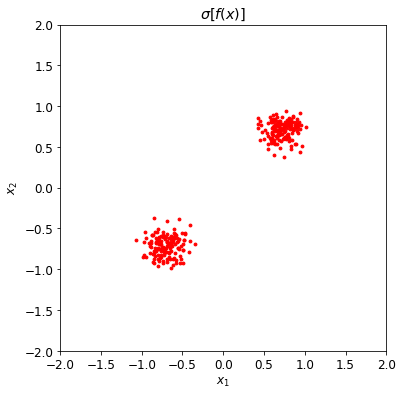

In [88]:
circles = CircleDataset(BATCH_SIZE, 2, sigma=0.12, include_zero=False)
circles.data @= get_rotation(-45)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(circles.data[:, 0], circles.data[:, 1], s=8, c='r')
ax.axis('scaled')
ax.set_title("$\sigma[f(x)]$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

plt.show()

In [89]:
class BayesianLinear(PyroModule):
    def __init__(self, in_features, out_features, hidden_features=50, n_layers=1, dropout=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.n_layers = n_layers
        self.dropout = dropout
        
        pipe = [PyroModule[nn.Linear](in_features, hidden_features),
                PyroModule[nn.ReLU]()]
        for i in range(n_layers-1):
            pipe += [PyroModule[nn.Linear](hidden_features, hidden_features),
                     PyroModule[nn.ReLU]()]
            if dropout != None:
                pipe += [PyroModule[nn.Dropout](p=dropout)]
            
        pipe += [PyroModule[nn.Linear](hidden_features, out_features)]
        if dropout != None:
            pipe += [PyroModule[nn.Dropout](p=dropout)]
        self.seq = PyroModule[nn.Sequential](*pipe)
        # See the paper
        stds = [4., 3., 2.25, 2, 2, 1.9, 1.75, 1.75, 1.7, 1.65]
        stds = stds[::-1][:n_layers+1][::-1]
        k = -1
        for i in range(len(self.seq)):
            if 'linear' in type(self.seq[i]).__name__.lower():
                k += 1
                out_size, in_size = self.seq[i].weight.shape 
                # We can't specify the device explicitly, thus using this hack
                self.seq[i].bias = PyroSample(dist.Normal(torch.tensor(0., device=DEVICE), 1.,
                                                          validate_args=False).expand([out_size]).to_event(1))
                self.seq[i].weight = PyroSample(dist.Normal(torch.tensor(0., device=DEVICE),
                                                            stds[k]/hidden_features**0.5, validate_args=False).expand([out_size,
                                                                                          in_size]).to_event(2))
        
    def forward(self, x, y):
        y_pr = self.seq(x)
        with pyro.plate("data", y.shape[0]):
            pyro.sample("obs", dist.Normal(y, 0.1).to_event(1), obs=y_pr)
        return y_pr.detach()

In [90]:
from IPython import display
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter

class ProgressPlotter:
    def __init__(self, losses, update_per=5):
        self.losses = losses
        self.update_per = update_per
        
    def start(self):
        self.time = time.time()
        
    def update(self, num_iter):
        if num_iter % self.update_per != 0:
            return
        old_time = self.time
        self.time = time.time()
        iter_time = (self.time - old_time)/self.update_per
      
        display.clear_output(wait=True)
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        if len(losses) > 3:
            losses_smoothed = savgol_filter(losses, min(2*(len(losses)//2)-1, 51), 3)
        else:
            losses_smoothed = losses
            
        ts = np.arange(len(losses), dtype=np.int)+1
        ax.plot(ts, losses_smoothed, color=f"C0")
        ax.plot(ts, losses, color=f"C0", alpha=0.3)
        ax.set_xlabel(f"Epoch ({iter_time:.2g} s/epoch)")
        ax.set_ylabel("$-ELBO$")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            
        plt.show()

In [91]:
gauss_loader = DataLoader(circles, batch_size=BATCH_SIZE, pin_memory=IS_CUDA,
                          shuffle=True, num_workers=N_WORKERS)

In [92]:
### pyro.clear_param_store()
pyro.set_rng_seed(1)

N_EPOCHS = 100
log_per = 5
n_hidden = 50
n_layers = 1

model = BayesianLinear(2, 1, n_layers=2, hidden_features=n_hidden).to(DEVICE)
guide = AutoDiagonalNormal(model, init_scale=1e-5)
# guide = AutoNormal(model)
# guide = AutoMultivariateNormal(model)
# svi = SVI(model, guide, Adam({"lr": 0.01}), Trace_ELBO(num_particles=32))
svi = SVI(model, guide, Adam({"lr": 1e-3}), TraceMeanField_ELBO(num_particles=32))

losses = []
pp = ProgressPlotter(losses)

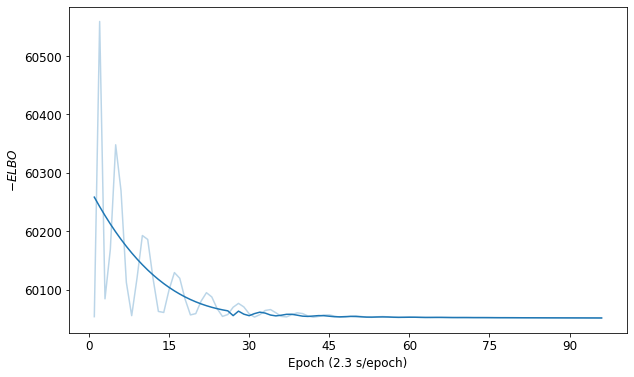

In [ ]:
pp.start()
for epoch in range(N_EPOCHS):
    total_loss = 0.
    for i, batch in enumerate(gauss_loader):
        x, y = batch
        x, y = x.float().to(DEVICE), y[:, 0].float().to(DEVICE)
        loss = svi.step(x, y) / y.numel()
        total_loss += loss
    total_loss /= len(gauss_loader)
    losses.append(total_loss)
    
    pp.update(epoch)

In [72]:
n_repeats = 50

xs = np.linspace(-2, 2)
ys = np.linspace(-2, 2)
X, Y = np.meshgrid(xs, ys)
X = X.ravel()
Y = Y.ravel()
Z = torch.from_numpy(np.stack((X, Y), axis=1))

test = TensorDataset(Z)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, pin_memory=IS_CUDA,
                         shuffle=False, num_workers=N_WORKERS)

means = []
stds = []
for x, in tqdm(test_loader):
    x = x.float().to(DEVICE)
    z = []
    for i in range(n_repeats):
        z.append(model.seq(x))
    z = torch.stack(z, dim=0)
    means.append(z.mean(dim=0))
    stds.append(z.std(dim=0))


means = torch.cat(means).detach().cpu().numpy().reshape(len(ys), len(xs))
stds  = torch.cat(stds).detach().cpu().numpy().reshape(len(ys), len(xs))
X = X.reshape(len(ys), len(xs))
Y = Y.reshape(len(ys), len(xs))

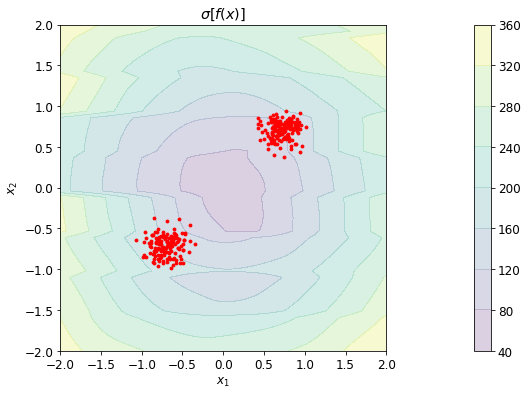

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

cm = ax.contourf(X, Y, stds, alpha=0.2)
fig.colorbar(cm)
ax.scatter(circles.data[:, 0], circles.data[:, 1], s=8, c='r')
ax.axis('scaled')
ax.set_title("$\sigma[f(x)]$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

plt.show()

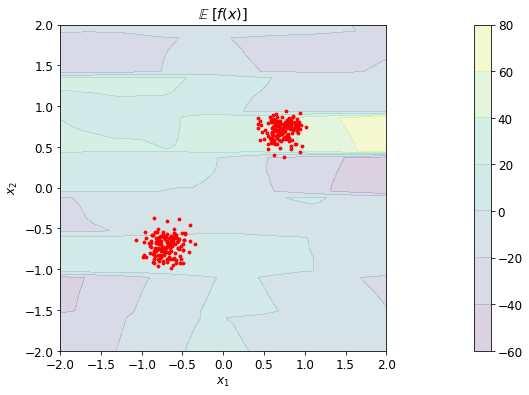

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

cm = ax.contourf(X, Y, means, alpha=0.2)
fig.colorbar(cm)
ax.set_title("$\mathbb{E}\;[f(x)]$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.axis('scaled')
ax.scatter(circles.data[:, 0], circles.data[:, 1], s=8, c='r')

plt.show()

In [77]:
n_repeats = 50

ts = np.linspace(0, 1)
xs = np.array([-1.2, -1.2])[None, :] + ts[:, None] * np.array([2.4, 2.4])[None, :]
xs = torch.from_numpy(xs)

test = TensorDataset(xs)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, pin_memory=IS_CUDA,
                         shuffle=False, num_workers=N_WORKERS)

means = []
stds = []
for x, in tqdm(test_loader):
    x = x.float().to(DEVICE)
    z = []
    for i in range(n_repeats):
        z.append(model.seq(x))
    z = torch.stack(z, dim=0)
    means.append(z.mean(dim=0))
    stds.append(z.std(dim=0))

means = torch.cat(means).detach().cpu().numpy().squeeze()
stds  = torch.cat(stds).detach().cpu().numpy().squeeze()

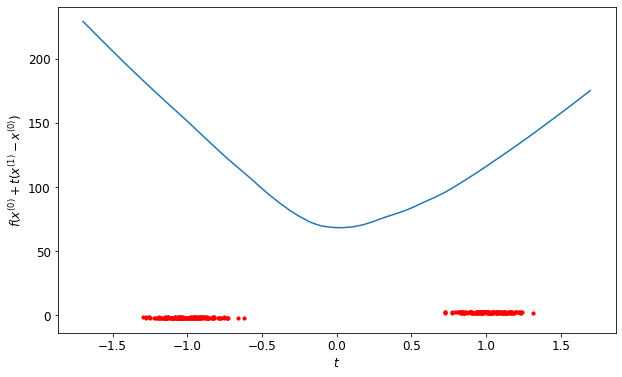

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

xs_proj = circles.data @ get_rotation(45)
ax.scatter(xs_proj[:, 0], circles.target[:, 0], c='r', s=10)

xs_proj = xs @ get_rotation(45)
ax.plot(xs_proj[:, 0], stds)
ax.set_xlabel("$t$")
ax.set_ylabel("$f(x^{(0)}+t(x^{(1)}-x^{(0)})$")
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.axis('scaled')

plt.show()